In [11]:
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [3]:
def load_data(path):
    df = pd.read_csv(path, sep='|')
    df = df.dropna()
    return df

def prepare_features_linear(df):
    X = df[[
        'duration', 'sum_support', 'sum_nuker', 'sum_initiator', 'sum_escape',
        'sum_durable', 'sum_disabler', 'sum_carry', 'sum_jungler', 'sum_pusher',
        'sum_agi', 'sum_int', 'sum_str', 'sum_melee', 'sum_ranged', 'sum_kills',
        'sum_deaths', 'sum_assists', 'mean_lasthits', 'mean_denies',
        'sum_observers', 'sum_towers', 'mean_gold_min', 'mean_exp_min']
    ]
    y = df['win_True']
    return X, y

def train_linear_model(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def evaluate_linear_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, predictions)
    plt.title("Actual vs. Predicted")
    plt.subplot(1, 2, 2)
    plt.hist(y_test - predictions, bins=50)
    plt.title("Residuals")
    plt.tight_layout()
    plt.show()

    print("MAE:", metrics.mean_absolute_error(y_test, predictions))
    print("MSE:", metrics.mean_squared_error(y_test, predictions))
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

def prepare_features_xgb(df):
    df['team_name'] = df['team_id']
    df = pd.get_dummies(df, prefix='team', columns=['team_name'])
    
    X = df[[
        'sum_support', 'sum_nuker', 'sum_initiator', 'sum_escape', 'sum_durable',
        'sum_disabler', 'sum_carry', 'sum_jungler', 'sum_pusher', 'sum_agi',
        'sum_int', 'sum_str', 'sum_melee', 'sum_ranged']
    ]
    y = df['win_True']
    return df, X, y

def train_xgb_with_grid_search(df, X, y, df_validation):
    max_depths = [6, 8, 10]
    reg_alphas = [0.5, 1.5, 2.5]
    reg_lambdas = [1.5, 2.5, 3.5]
    n_estimators_list = [100, 300, 500]

    for depth in max_depths:
        for alpha in reg_alphas:
            for lam in reg_lambdas:
                for estimators in n_estimators_list:
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
                    model = XGBClassifier(
                        max_depth=depth, reg_alpha=alpha, reg_lambda=lam,
                        n_estimators=estimators, objective='binary:logistic',
                        eval_metric='logloss', use_label_encoder=False
                    )
                    model.fit(X_train, y_train)

                    pred_test = model.predict(X_test)
                    acc_test = accuracy_score(y_test, pred_test)
                    print(f"Grid Search: depth={depth}, alpha={alpha}, lambda={lam}, estimators={estimators}, Test Acc={acc_test:.2%}")

                    X_val = df_validation[[
                        'sum_support', 'sum_nuker', 'sum_initiator', 'sum_escape', 'sum_durable',
                        'sum_disabler', 'sum_carry', 'sum_jungler', 'sum_pusher', 'sum_agi',
                        'sum_int', 'sum_str', 'sum_melee', 'sum_ranged']
                    ]
                    y_val = df_validation['win_True']
                    pred_val = model.predict(X_val)
                    acc_val = accuracy_score(y_val, pred_val)
                    print(f"Validation Accuracy: {acc_val:.2%}\n")

In [19]:
df = load_data('../data/silver/data_transformed.csv')

In [28]:
df.columns

Index(['year', 'match_id', 'start_time', 'duration', 'sum_support',
       'sum_nuker', 'sum_initiator', 'sum_escape', 'sum_durable',
       'sum_disabler', 'sum_carry', 'sum_jungler', 'sum_pusher', 'sum_agi',
       'sum_int', 'sum_str', 'sum_melee', 'sum_ranged', 'sum_kills',
       'sum_deaths', 'sum_assists', 'mean_lasthits', 'mean_denies',
       'sum_observers', 'sum_towers', 'mean_gold_min', 'mean_exp_min',
       'sum_roles', 'win_False', 'win_True', 'team_id'],
      dtype='object')

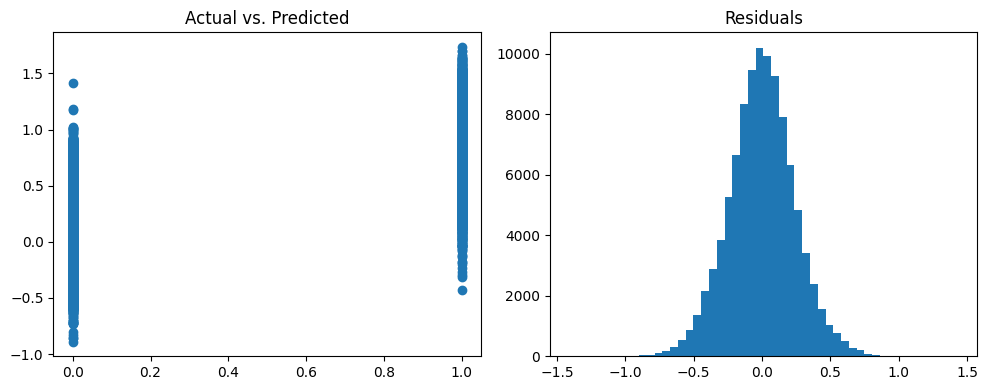

MAE: 0.1882102093966364
MSE: 0.05806110277853519
RMSE: 0.2409587159214939


In [21]:
# Linear model
X_linear, y_linear = prepare_features_linear(df)
X_train, X_test, y_train, y_test = train_test_split(X_linear, y_linear, test_size=0.3, random_state=42)
linear_model = train_linear_model(X_train, y_train)
evaluate_linear_model(linear_model, X_test, y_test)

In [ ]:
#Logistic Regression

df_all = df.copy()  

# Define features and target
feature_cols = [
    'sum_support', 'sum_nuker', 'sum_initiator', 'sum_escape', 'sum_durable',
    'sum_disabler', 'sum_carry', 'sum_jungler', 'sum_pusher',
    'sum_agi', 'sum_int', 'sum_str',
    'sum_melee', 'sum_ranged'
]

df_validation = df_all[df_all['year'] == 2025]
df_train = df_all[df_all['year'] != 2025]

X_train = df_train[feature_cols]
y_train = df_train['win_True']

X_test = df_validation[feature_cols]
y_test = df_validation['win_True']

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5079240546053664
[[7960 4758]
 [7786 4988]]
              precision    recall  f1-score   support

       False       0.51      0.63      0.56     12718
        True       0.51      0.39      0.44     12774

    accuracy                           0.51     25492
   macro avg       0.51      0.51      0.50     25492
weighted avg       0.51      0.51      0.50     25492



In [30]:
# XGBoost model
df_all, X_xgb, y_xgb = prepare_features_xgb(df)
df_validation = df_all[df_all['year'] == 2021]
df_train = df_all[df_all['year'] != 2021]
_, X_train_xgb, y_train_xgb = prepare_features_xgb(df_train)
train_xgb_with_grid_search(df_train, X_train_xgb, y_train_xgb, df_validation)

/tmp/ipykernel_36115/2667060656.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['team_name'] = df['team_id']


: 

In [1]:
from xgboost import XGBClassifier

model = XGBClassifier(
    max_depth=6,
    n_estimators=300,
    reg_alpha=1,
    reg_lambda=1,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

NameError: name 'X_train' is not defined